# Tutorial on Rockit
For more information on Rockit (Rapid Optimal Control Kit), check out https://gitlab.kuleuven.be/meco-software/rockit

A gallery of Rockit examples; https://meco-software.pages.gitlab.kuleuven.be/rockit/examples/

Today's topics

1) Optimal control recap

2) Rockit installation and basic syntax (state, control, objective, fixed time)

3) Formulating an OCP: Car example (free time, continuous time dynamics)

4) Transcription methods (SS, MS, DC)

5) Beyond canonical optimal control (include_first and include_last, discrete time dynamics, variables, parameters, functions, MPC, multi stage, grid, t vs T)

6) Tips on solving optimal control problems


## Optimal control recap
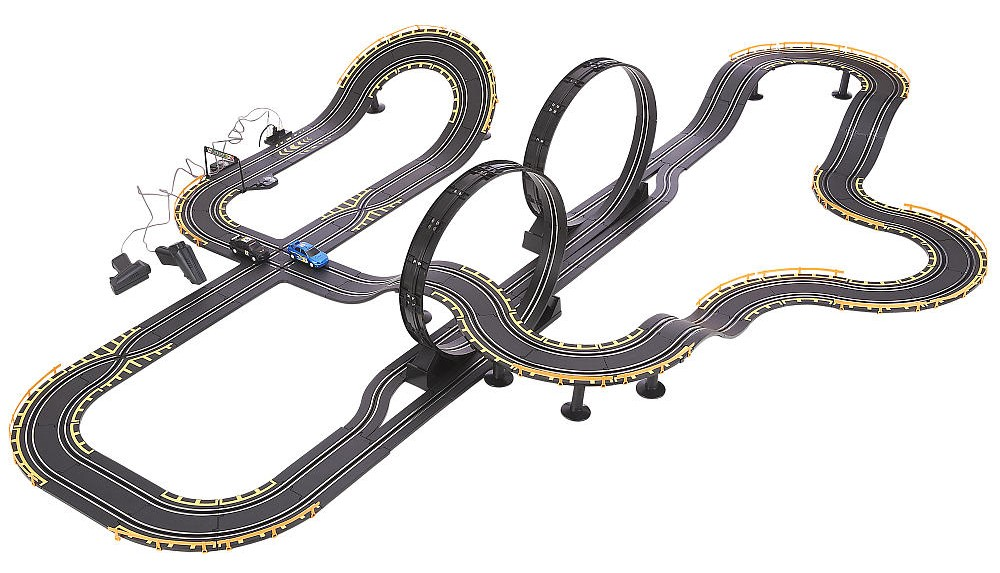

* Our system to optimize involves (controllable) dynamics: 
$\dot{x}(t)=f(x(t),u(t))$

* Find the control signal $u(\bullet)$ that makes a system move optimally
  * State trajectory $x(\bullet) : \mathbb{R} \mapsto \mathbb{R}^{n_x}$
  * Control trajectory $u(\bullet) : \mathbb{R} \mapsto \mathbb{R}^{n_u}$

$\begin{aligned}
& \underset{x(\bullet),u(\bullet)}{\text{minimize}}
& &  J(x(\bullet),u(\bullet)) & \text{objective} \\\\
& \text{subject to} 
& & \dot{x}(t) = f(x(t),u(t)) ,\quad t \in [0,T] & \quad \text{dynamic constraints}\\\\
& & & h(x(t),u(t)) \leq 0 ,\quad t \in [0,T] & \quad \text{path constraints}\\\\
& & & B(x(0),x(T)) \leq 0 & \quad \text{boundary constraints}\\\\
\end{aligned}
$



## Rockit installation and basic syntax

```conda create --name rockit python=3.10```

```conda activate rockit```

```pip install rockit-meco```

$
\begin{aligned}
& \underset{x_1(\bullet),x_2(\bullet),u(\bullet)}{\text{minimize}}
& &  \int_0^T \left[x_1^2(t)+x_2^2(t)+u^2(t) \right] dt + x_1^2(T) \\
& \text{subject to} 
& & \dot{x}_1(t) = (1-x_2^2(t)) x_1(t)-x_2(t)+u(t) ,\quad t \in [0,T]\\
& & & \dot{x}_2(t) = x_1(t),\quad t \in [0,T] \\
& & & x_1(t) \geq -0.25 ,\quad t \in [0,T]\\
& & & -1 \leq u(t) \leq 1 ,\quad t \in [0,T]\\
& & & x_1(0) = 0\\
& & & x_2(0) = 1\\
\end{aligned}
$

In [7]:
from rockit import *
from numpy import *
import matplotlib.pyplot as plt

# Start an optimal control environment with a time horizon of 10 seconds
ocp = Ocp(T=10)

# Define two scalar states
x1 = ocp.state()
x2 = ocp.state()

# Define control input
u = ocp.control()

# Lagrange objective term
ocp.add_objective(ocp.integral(u**2 + x1**2 + x2**2))

# Mayer objective term
ocp.add_objective(ocp.at_tf(x1**2))

$
\begin{aligned}
& \underset{x_1(\bullet),x_2(\bullet),u(\bullet)}{\text{minimize}}
& &  \int_0^T \left[x_1^2(t)+x_2^2(t)+u^2(t) \right] dt + x_1^2(T) \\
& \text{subject to} 
& & \dot{x}_1(t) = (1-x_2^2(t)) x_1(t)-x_2(t)+u(t) ,\quad t \in [0,T]\\
& & & \dot{x}_2(t) = x_1(t),\quad t \in [0,T] \\
& & & x_1(t) \geq -0.25 ,\quad t \in [0,T]\\
& & & -1 \leq u(t) \leq 1 ,\quad t \in [0,T]\\
& & & x_1(0) = 0\\
& & & x_2(0) = 1\\
\end{aligned}
$

In [8]:
# Specify differential equations for states
ocp.set_der(x1, (1-x2**2)*x1 - x2 + u)
ocp.set_der(x2, x1)

# Path constraints
ocp.subject_to(x1 >= -0.25)
ocp.subject_to(-1 <= (u <= 1))

# Boundary constraints
ocp.subject_to(ocp.at_t0(x1) == 0)
ocp.subject_to(ocp.at_tf(x2) == 1)

# Pick an NLP solver backend
ocp.solver('ipopt')

# Pick a solution method (expl_euler)
ocp.method(MultipleShooting(N=10, M=1, intg='rk'))

# Solve
sol = ocp.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       82
Number of nonzeros in inequality constraint Jacobian.:       22
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables............................:       32
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       22
Total number of inequality constraints...............:       22
        inequality constraints with only lower bounds:       11
   inequality constraints with lower and upper bounds:       11
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 2.21e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

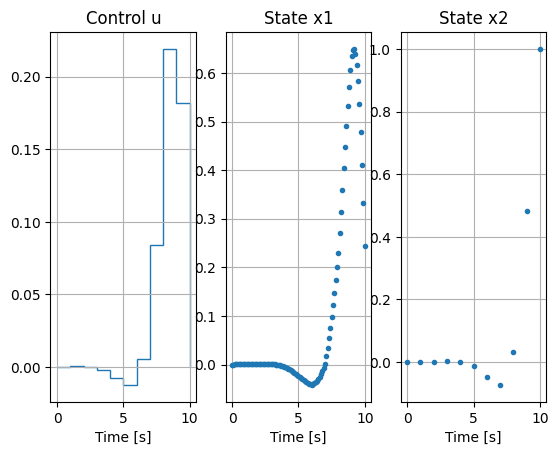

In [9]:
# Visualize results
t_u, u_sol = sol.sample(u, grid='control')
t_x1, x1_sol = sol.sample(x1, grid='integrator', refine=10) # refine go inbetween the grid points
t_x2, x2_sol = sol.sample(x2, grid='control')

plt.figure()
plt.subplot(1, 3, 1)
plt.stairs(u_sol[:-1], t_u)
plt.xlabel("Time [s]")
plt.title('Control u')
plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(t_x1, x1_sol, '.')
plt.xlabel("Time [s]")
plt.title('State x1')
plt.grid(True)
plt.subplot(1, 3, 3)
plt.plot(t_x2, x2_sol, '.')
plt.xlabel("Time [s]")
plt.title('State x2')
plt.grid(True)
plt.show(block=True)

## Formulating an OCP: Car example

* $p,v$: position and velocity along track [m], [m/s]
* $F$: forward thrust [N], $m=500$ [kg]

$
\begin{aligned}
& \underset{p(\bullet),v(\bullet),F(\bullet),T}{\text{minimize}}
& &  T \\
& \text{subject to} 
& & \dot{p}(t) = v(t) ,\quad t \in [0,T]\\
& & & \dot{v}(t) = (F(t)-2 v^2(t))/m,\quad t \in [0,T] \\
& & & v(t) \geq 0 ,\quad t \in [0,T]\\
& & & -2500 \leq F(t) \leq 2500 ,\quad t \in [0,T]\\
& & & v(t) \leq 20-10 \sin(\pi p(t)/250) ,\quad t \in [0,T]\\
& & & p(0) = 0, v(0) = 0\\
& & & p(T) = 1000, v(T) = 0\\
\end{aligned}
$

A free end-time can be specified with ```ocp = Ocp(T=FreeTime(1.0))``` (initial guess 1.0)

Use ```ocp.T``` to access the optimization variable 



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      184
Number of nonzeros in inequality constraint Jacobian.:       85
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:       63
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       64
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:       21
        inequality constraints with only upper bounds:       42

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.00e+03 8.68e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

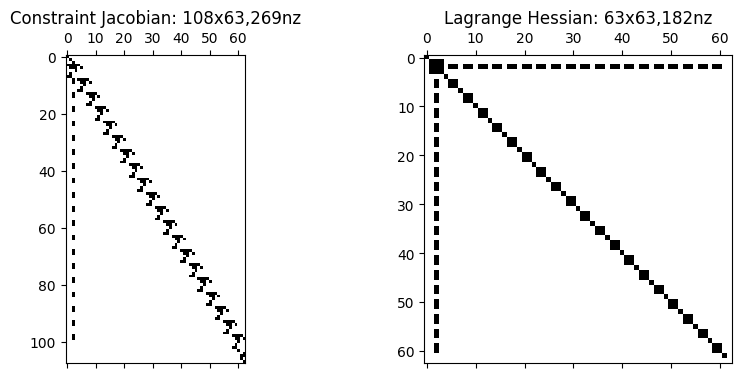

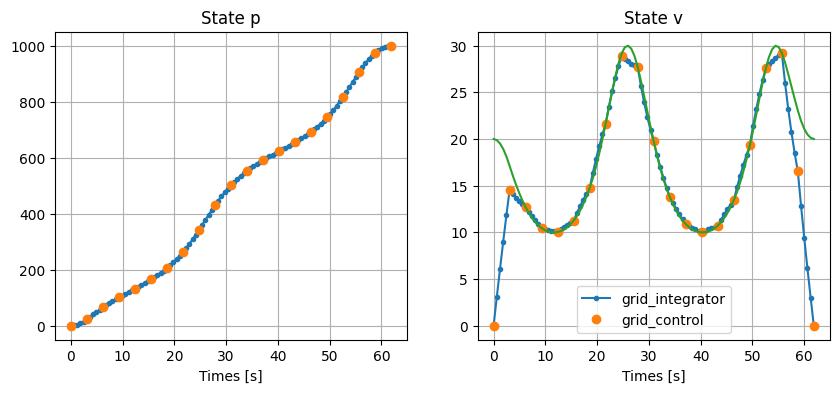

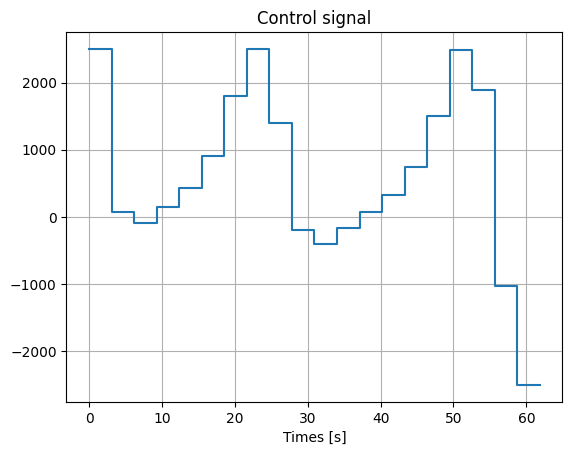

In [11]:
from rockit import *
from numpy import sin, pi
import matplotlib.pyplot as plt

ocp = Ocp(T=FreeTime(1.0))

# Define constants
m = 500.0
c = 2
d = 1000
F_max = 2500

# Define states
p = ocp.state()
v = ocp.state()

# Defince controls
F = ocp.control()

# Specify ODE
ocp.set_der(p, v)
ocp.set_der(v, 1/m * (F - c*v**2))

# Lagrange objective
ocp.add_objective(ocp.T)

# Path constraints
ocp.subject_to(-F_max <= (F <= F_max))
ocp.subject_to(0 <= (v <= 20 - 10*sin(pi*p/250)))

# Initial constraints
ocp.subject_to(ocp.at_t0(p)==0)
ocp.subject_to(ocp.at_t0(v)==0)

# End constraints
ocp.subject_to(ocp.at_tf(p)==d)
ocp.subject_to(ocp.at_tf(v)==0)

# Pick a solver
ocp.solver('ipopt')

# Choose a solution method
ocp.method(MultipleShooting(N=20, M=1, intg='rk'))

ocp.spy()

# solve
sol = ocp.solve()

from pylab import *

# Post-processing
tsa, pa = sol.sample(p, grid='control')
tsa, va = sol.sample(v, grid='control')

tsb, pb = sol.sample(p, grid='integrator', refine=5)
tsb, vb = sol.sample(v, grid='integrator', refine=5)


figure(figsize=(10, 4))
subplot(1, 2, 1)
plot(tsb, pb, '.-')
plot(tsa, pa, 'o')
xlabel("Times [s]")
grid(True)
title('State p')

subplot(1, 2, 2)
plot(tsb, vb, '.-')
plot(tsa, va, 'o')
plot(tsb, 20 - 10*sin(pi*pb/250))
legend(['grid_integrator', 'grid_control'])
xlabel("Times [s]")
title('State v')
grid(True)

tsol, usol = sol.sample(F, grid='control')

figure()
step(tsol,usol,where='post')
title("Control signal")
xlabel("Times [s]")
grid(True)

plt.show(block=True)

## Transcription methods (SS, MS, DC and ```ocp.spy()```)

```# Choose a solution method```

```ocp.method(SingleShooting(N=20, M=1, intg='rk'))```

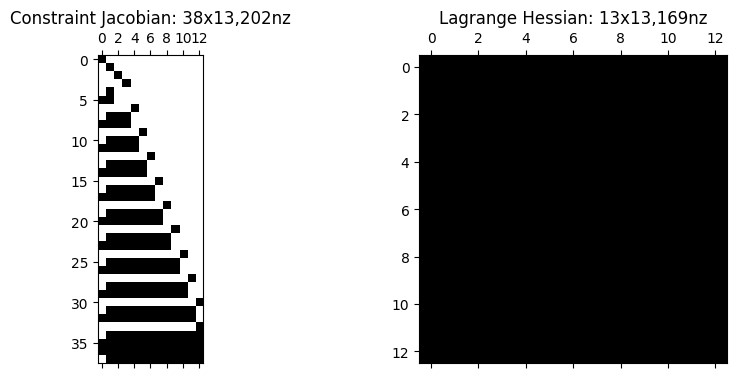

```ocp.method(MultipleShooting(N=20, M=1, intg='rk'))```

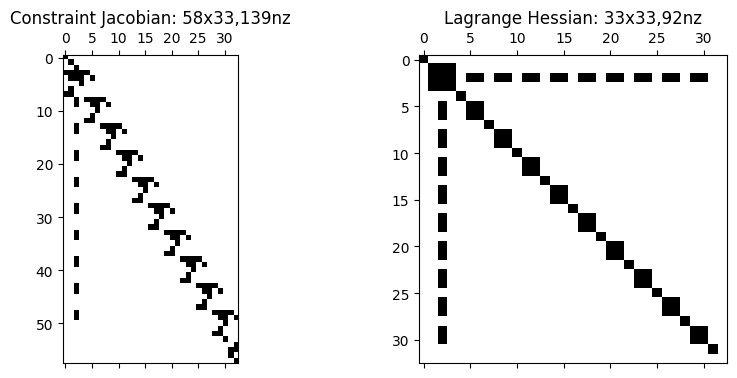

```ocp.method(DirectCollocation(N=20, intg='rk'))```

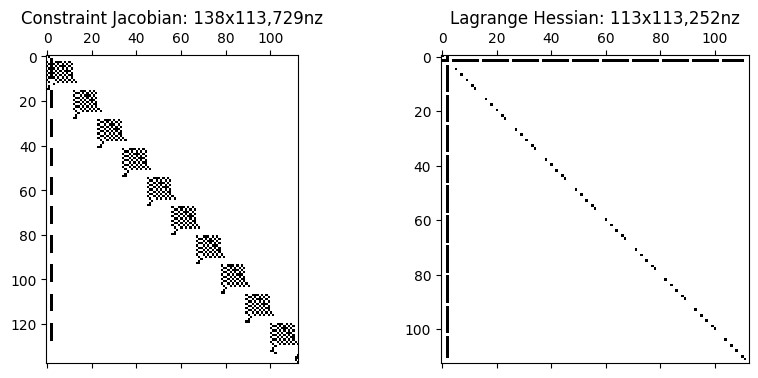

## Beyond canonical optimal control

* include_first and include_last; e.g. If position is already fixed at t0 by initial constraints: include_first = False avoids adding a redundant constraint.

`ocp.subject_to(-pos_min <= (pos <= pos_max), include_first=False)`

</br>

* discrete time dynamics; use an update rule for a discrete state (in stead of `ocp.set_der()`), e.g. if you want to use your own integrator.

`ocp.set_next(x, -x)`

</br>

* variables; e.g. design variables, slack variables.

$
\begin{aligned}
& \underset{x(\bullet),u(\bullet), \color{red}{m}}{\text{minimize}}
& &  J(x(\bullet),u(\bullet),{\color{red}{m}}) & \text{objective} \\\\
& \text{subject to} 
& & \dot{x}(t) = f(x(t),u(t),{\color{red}{m}}) ,\quad t \in [0,T] & \quad \text{dynamic constraints}\\\\
& & & h(x(t),u(t)) \leq 0 ,\quad t \in [0,T] & \quad \text{path constraints}\\\\
& & & B(x(0),x(T)) \leq 0 & \quad \text{boundary constraints}\\\\
\end{aligned}
$

A variable can be specified as `m = ocp.variable()`

</br>

* parameters; parametric optimization (not optimized).

$
\begin{aligned}
& \underset{x(\bullet),u(\bullet)}{\text{minimize}}
& &  J(x(\bullet),u(\bullet),{\color{red}{p}}) & \text{objective} \\\\
& \text{subject to} 
& & \dot{x}(t) = f(x(t),u(t),{\color{red}{p}}) ,\quad t \in [0,T] & \quad \text{dynamic constraints}\\\\
& & & h(x(t),u(t)) \leq 0 ,\quad t \in [0,T] & \quad \text{path constraints}\\\\
& & & B(x(0),x(T)) \leq 0 & \quad \text{boundary constraints}\\\\
\end{aligned}
$

A parameter can be specified as `p = ocp.parameter()`

Fast re-solves:

`ocp.set_value(p, 5)`

`sol1 = ocp.solve()`

`ocp.set_value(p, 6)`

`sol2 = ocp.solve()`

</br>

* functions

In [12]:
from rockit import *
from numpy import sin, pi
from casadi import vertcat
import numpy as np
import matplotlib.pyplot as plt

ocp = Ocp(T=FreeTime(1.0))

# Define constants
m = 500
c = 2
d = 1000

# Define states
p = ocp.state()
v = ocp.state()

# Defince controls
F = ocp.control()

# Specify ODE
ocp.set_der(p, v)
ocp.set_der(v, 1/m * (F - c * v**2))

# Lagrange objective
ocp.add_objective(ocp.T)

# Define parameters
F_max = ocp.parameter(grid='control')
p0 = ocp.parameter()

# Path constraints
ocp.subject_to(-F_max <= (F<= F_max))
ocp.subject_to(v >= 0)

# Initial constraints
ocp.subject_to(ocp.at_t0(p)==p0)
ocp.subject_to(ocp.at_t0(v)==0)

# End constraints
ocp.subject_to(ocp.at_tf(p)==d)
ocp.subject_to(ocp.at_tf(v)==0)

# Pick a solver
ocp.solver('ipopt')

# Choose a solution method
ocp.method(MultipleShooting(N=20,M=1,intg='rk'))

# Set values for parameters
ocp.set_value(p0, 1)
ocp.set_value(F_max, 2500*np.ones(20))

# Translate problem to function
T = ocp.value(ocp.T)
states = ocp.sample(vertcat(p,v), grid='control')[1]
controls = ocp.sample(F, grid='control-')[1]
test = ocp.to_function('test', [p0, ocp.sample(F_max,grid='control-')[1], T, states, controls], [ocp.sample(F,grid='control')[1], T, states, controls])

# Initial value
sol_T = 1.0
sol_states = 0
sol_controls = 0

# Solve problem for different values for parameters, initializing with previous solution
signal1, sol_T, sol_states1, sol_controls = test(0, 2500*np.ones(20), sol_T, sol_states, sol_controls)
signal2, sol_T, sol_states2, sol_controls = test(0, 2500*np.ones(20), sol_T, sol_states1, sol_controls)
signal3, sol_T, sol_states3, sol_controls = test(0, 2000*np.ones(20), sol_T, sol_states2, sol_controls)


print(signal1[:4], sol_states1[:4])
print(signal2[:4], sol_states2[:4])
print(signal3[:4], sol_states3[:4])

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      184
Number of nonzeros in inequality constraint Jacobian.:       43
Number of nonzeros in Lagrangian Hessian.............:      101

Total number of variables............................:       63
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       43
        inequality constraints with only lower bounds:       22
   inequality constraints with lower and upper bounds:       21
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.00e+03 3.55e-15  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

* MPC, use `to_function()` and check `motion_planning_MPC.py` example

</br>

* multi stage, i.e. multiple optimal control problems stitched together, e.g. rocket launch

$
\begin{aligned}
& \underset{x_1(\bullet),u_1(\bullet),x_2(\bullet),u_2(\bullet)}{\text{minimize}}
& &  {\color{red}{J}}_1(x_1(\bullet),u_1(\bullet))+{\color{red}{J}}_2(x_2(\bullet),u_2(\bullet)) \\
& \text{subject to} 
& & \dot{x}_1(t) = {\color{red}{f}}_1(x_1(t),u_1(t)) ,\quad t \in \color{red}{[0,T_1]}\\
& & & \dot{x}_2(t) = {\color{red}{f}}_2(x_2(t),u_2(t)) ,\quad t \in \color{red}{[T_1,T_2]}\\
& & & h_1(x_1(t),u_1(t)) \leq 0 ,\quad t \in [0,T_1]\\
& & & h_2(x_2(t),u_2(t)) \leq 0 ,\quad t \in [T_1,T_2]\\
& & & B_1(x_1(0),x_1(T_1)) \leq 0\\
& & & \color{red}{C}(x_1(T_1),x_2(T_1)) \leq 0\\
& & & B_2(x_2(T_1),x_2(T_2)) \leq 0\\
\end{aligned}
$


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       41
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       18
Total number of inequality constraints...............:       12
        inequality constraints with only lower bounds:       12
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.81e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

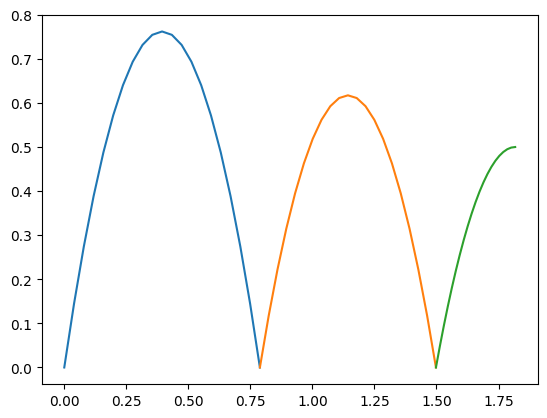

In [13]:
from rockit import Ocp, DirectMethod, MultipleShooting, FreeTime
import matplotlib.pyplot as plt


def create_bouncing_ball_stage(ocp):
    """
    Create a bouncing ball stage.

    This function creates a stage of a bouncing ball that bounces no higher
    than 5 meters above the ground.

    Returns
    -------
    stage : :obj:`~rockit.stage.Stage`
        An ocp stage describing the bouncing ball
    p : :obj:`~casadi.MX`
        position variable
    v : :obj:`~casadi.MX`
        velocity variable
    """
    stage = ocp.stage(t0=FreeTime(0), T=FreeTime(1))

    p = stage.state()
    v = stage.state()

    stage.set_der(p, v)
    stage.set_der(v, -9.81)

    stage.subject_to(stage.at_t0(v) >= 0)
    stage.subject_to(p >= 0)
    stage.method(MultipleShooting(N=1, M=20, intg='rk'))

    return stage, p, v


ocp = Ocp()

# Shoot up the ball
stage1, p1, v1 = create_bouncing_ball_stage(ocp)
ocp.subject_to(stage1.t0 == 0)  # Stage starts at time 0
ocp.subject_to(stage1.at_t0(p1) == 0)
ocp.subject_to(stage1.at_tf(p1) == 0)

# After bounce 1
stage2, p2, v2 = create_bouncing_ball_stage(ocp)
ocp.subject_to(stage2.at_t0(v2) == -0.9 * stage1.at_tf(v1))
ocp.subject_to(stage2.at_t0(p2) == stage1.at_tf(p1))
ocp.subject_to(stage2.t0 == stage1.tf)
ocp.subject_to(stage2.at_tf(p2) == 0)

# After bounce 2
stage3, p3, v3 = create_bouncing_ball_stage(ocp)
ocp.subject_to(stage3.at_t0(v3) == -0.9 * stage2.at_tf(v2))
ocp.subject_to(stage3.at_t0(p3) == stage2.at_tf(p2))
ocp.subject_to(stage3.t0 == stage2.tf)
ocp.subject_to(stage3.at_tf(v3) == 0)
ocp.subject_to(stage3.at_tf(p3) == 0.5)  # Stop at a half meter!

ocp.solver('ipopt')

# Solve
sol = ocp.solve()

# Plot the 3 bounces
plt.figure()
ts1, ps1 = sol(stage1).sample(p1, grid='integrator')
ts2, ps2 = sol(stage2).sample(p2, grid='integrator')
ts3, ps3 = sol(stage3).sample(p3, grid='integrator')
plt.plot(ts1, ps1)
plt.plot(ts2, ps2)
plt.plot(ts3, ps3)

plt.show(block=True)

</br>

* Constrain your problem on different grids, e.g. `grid='control', grid='integrator'`

</br>

* `ocp.t` for time vector

</br>

* `ocp.T` for total time

## Tips on solving optimal control problems

* Start with a fixed time-horizon

* Start with good initial guesses (value, vector or expression as function of time), e.g. `ocp.set_initial(x, sin(ocp.t))`
* Start with only initial constraints and gradually add more constraints
* Start with hard-coded control signals, e.g. `u = 1` instead of `u = ocp.control()`. Does the system evolve as expected?
* Some constraints make the problem easier to solve, e.g. `ocp.subject_to(-0.5 <= pitch <= 0.5)` for a passenger aircraft. You don't want the solver to explore loopings
* If your system has a natural equilibrium state, you can add some "regularization" i.e. quadratic penalty of your actual state w.r.t. to that equilibrium state. Again, this can avoid ending up in funny trajectories that are locally infeasible  
* If the solver does not converge, you can still make plots with `sol = ocp.non_converged_solution`, or show problematic constraints with `ocp.show_infeasibilities(1e-6)`
* Scale your decision variables on physical insights such that they are order of magnitude 0.01-100. If you model rocket launches, don't use [N] as unit for thrust control; use [MN]
* Some solvers perform automatic scaling. This can be counterproductive. Consider disabling that, e.g. `ocp.solver('ipopt', struct('ipopt', struct('mumps_scaling', 0)))`

